# 📊 Análisis Post-Modelo del Dataset

En esta sección se analiza el desempeño del modelo final sobre el **conjunto de test**, centrándonos en:

- Evaluar cómo funciona el modelo globalmente
- Analizar el rendimiento por grupos académicos (titulación, etapa y subetapa)
- Detectar posibles sesgos o áreas con bajo desempeño
- Generar alertas y recomendaciones para la mejora del modelo o la recolección de datos

El objetivo es entender no solo **qué tan preciso es el modelo**, sino **dónde funciona mejor y dónde falla**.

---

## 1️⃣ Carga del Modelo Final y del Conjunto de Test

- El modelo ya entrenado se carga desde el almacenamiento definido (`modelo_final_explicable`).  
- Se extrae el conjunto de test correspondiente al **último curso académico** para garantizar que los datos no hayan sido vistos durante el entrenamiento.  
- Se preparan las variables de modelado y el target para la predicción.

📌 Esto asegura que las métricas calculadas reflejen el **rendimiento real del modelo** sobre datos nuevos.

---

## 2️⃣ Predicciones del Modelo

- Se calculan:

  - **Etiquetas predichas** (`prediction_label`)  
  - **Probabilidades de éxito** (`prediction_score`)

- Se reengancha el target real para poder comparar las predicciones con los resultados reales.  

📌 Esto permite calcular métricas como **Accuracy** y **AUC** tanto de forma global como por grupos.

---

## 3️⃣ Análisis por Grupos Académicos

Se realiza un desglose del desempeño del modelo por:

1. **Titulación (`TITULACION`)**
2. **Etapa (`PL_ETAPA`)**
3. **Subetapa (`PL_SUBETAPA`)**, si existe en el dataset

Para cada grupo se calcula:

- Número de observaciones (`n`)  
- **Accuracy**: porcentaje de aciertos  
- **AUC**: capacidad del modelo para discriminar entre clases

Además, se identifican automáticamente los **5 mejores y 5 peores grupos** según Accuracy.

---

## 4️⃣ Visualización de Resultados

- Se generan **gráficos de barras** mostrando los grupos con mejor desempeño.  
- Esto permite identificar visualmente:

  - Qué titulaciones, etapas o subetapas presentan mayor confiabilidad en las predicciones
  - Qué grupos podrían requerir atención o revisión de datos

📌 La visualización facilita la interpretación de los resultados por stakeholders académicos.

---

## 5️⃣ Alertas y Recomendaciones Automáticas

- Se generan alertas para grupos con **Accuracy por debajo de un umbral configurable** (por ejemplo, 0.7).  
- Esto ayuda a:

  - Detectar titulaciones o etapas donde el modelo es menos fiable  
  - Tomar decisiones sobre **recolección de datos adicional** o **revisión de características del grupo**  
  - Priorizar intervenciones en los grupos con peor desempeño

---

## 6️⃣ Interpretación de Resultados

- Los grupos con **Accuracy alta (>0.9)** indican que el modelo predice muy bien el éxito de los candidatos.  
- Los grupos con **Accuracy baja (<0.6–0.7)** requieren atención, ya que el modelo podría estar sesgado o los datos ser insuficientes o ruidosos.  
- El análisis por **AUC** complementa el análisis de Accuracy, mostrando la capacidad de discriminación del modelo incluso si los grupos son desbalanceados.

---

## 7️⃣ Beneficios de Este Análisis

- Permite evaluar el **rendimiento real del modelo** más allá de las métricas globales.  
- Facilita la identificación de **sesgos por segmentación académica**.  
- Proporciona información clave para mejorar:

  - Estrategias de admisión o seguimiento de candidatos  
  - Preparación de submodelos específicos por áreas  
  - Recolección y limpieza de datos en grupos críticos  

📌 Los resultados obtenidos en esta fase **cierran el ciclo de modelado**, conectando la predicción con decisiones operativas y estratégicas.


---


Transformation Pipeline and Model Successfully Loaded
✅ Modelo cargado correctamente.
⚠️ No hay cursos válidos. Se usará todo el dataset de test.
✅ Filas de test después de eliminar NaN en target: 536598
✅ Feature 'vinculacion_previa' reconstruida. Columnas usadas: ['CH_ALUMNO__PC', 'CH_ESTUDIANTE__PC', 'CH_ANTIGUO_ALUMNO__PC', 'CH_ALUMNI__PC', 'CH_ANTIGUOALUMNO_INTERCAMBIO', 'CH_HIJO_ANTIGUO_ALUMNO__PC']
✅ Predicciones realizadas. Número de filas: 536598

📊 Resultados por TITULACION (Top 5 oportunidades):
                                           TITULACION      n    AUC  Accuracy  \
0  Grado en Gestión Aplicada / Bachelor in Applie...  10593  0.886     0.709   
1                  Grado en Estudios de Arquitectura  16705  0.902     0.665   
2                                Grado en Enfermería  16018  0.897     0.593   
3                                Grado en Psicología  19712  0.915     0.579   
4                                  Grado en Medicina  45177  0.887     0.461   

   Acc

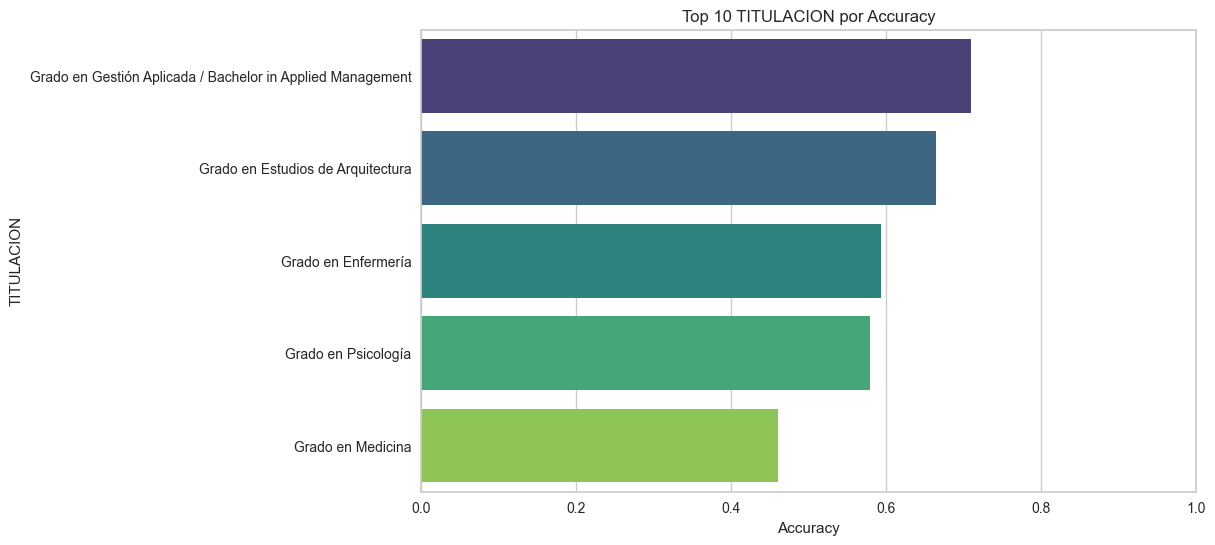


⚠️ ALERTA: 4 TITULACION con Accuracy < 0.7:
                          TITULACION  Accuracy      n
1  Grado en Estudios de Arquitectura     0.665  16705
2                Grado en Enfermería     0.593  16018
3                Grado en Psicología     0.579  19712
4                  Grado en Medicina     0.461  45177

⚠️ No hay columna 'ETAPA_SUBETAPA' para análisis.

✅ Análisis post-modelo completado con accuracy por clase y sin errores de NaN.


In [3]:
# ============================================================
# SCRIPT POST-MODELO COMPLETO CON ACCURACY POR CLASE (CORREGIDO)
# ============================================================

import pandas as pd
import numpy as np
from pycaret.classification import load_model, predict_model
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 0️⃣ CARGA DEL MODELO
# ============================================================
ruta_modelo = r"..\datos\04. Modelos\modelo_final_grado"
modelo = load_model(ruta_modelo)
print("✅ Modelo cargado correctamente.")

# ============================================================
# 1️⃣ CARGA DEL DATASET DE TEST
# ============================================================
ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

# Convertir PL_CURSO_ACADEMICO a numérico
df['PL_CURSO_ACADEMICO'] = pd.to_numeric(df['PL_CURSO_ACADEMICO'], errors='coerce')

# Filtrar por curso académico más reciente
if df['PL_CURSO_ACADEMICO'].dropna().empty:
    test_df_full = df.copy()
    print("⚠️ No hay cursos válidos. Se usará todo el dataset de test.")
else:
    ultimo_curso = df['PL_CURSO_ACADEMICO'].max()
    test_df_full = df[df['PL_CURSO_ACADEMICO'] == ultimo_curso].copy()
    print(f"✅ Datos de test filtrados por curso {ultimo_curso}. Filas: {len(test_df_full)}")

# ============================================================
# 2️⃣ FILTRAR NAs DEL TARGET
# ============================================================
test_df_full = test_df_full.dropna(subset=[target]).reset_index(drop=True)
test_df_full[target] = test_df_full[target].astype(int)  # 🔹 Asegurar binario
print(f"✅ Filas de test después de eliminar NaN en target: {len(test_df_full)}")

# ============================================================
# 3️⃣ VARIABLES DEL MODELO
# ============================================================
vars_excluir = [
    target, 'desmatriculado', 'MINIMUMPAYMENTPAYED',
    'CH_PAGO_SUPERIOR', 'STAGENAME', 'PL_SUBETAPA',
    'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NAMEX', 'YEARPERSONBIRTHDATE'
]

test_X = test_df_full[[c for c in test_df_full.columns if c not in vars_excluir]].copy()
test_y = test_df_full[target].reset_index(drop=True)

# ============================================================
# 4️⃣ RECONSTRUIR FLAGS DE NA Y RELLENAR NAs
# ============================================================
vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c'
]

for v in vars_cero_logico:
    if v in test_X.columns:
        test_X[f'flag_{v}_na'] = test_X[v].isna().astype(int)
        test_X[v] = test_X[v].fillna(0)

# Rellenar cualquier otro NA restante con 0
test_X = test_X.fillna(0)

# ============================================================
# 🔁 RECONSTRUIR FEATURE: VINCULACIÓN PREVIA
# ============================================================

cols_vinculacion = [
    'CH_ALUMNO__PC', 'CH_ESTUDIANTE__PC', 'CH_ANTIGUO_ALUMNO__PC',
    'CH_ALUMNI__PC', 'CH_ANTIGUOALUMNO_INTERCAMBIO',
    'CH_HIJO_ANTIGUO_ALUMNO__PC'
]

existentes = [c for c in cols_vinculacion if c in test_df_full.columns]

if existentes:
    test_df_full['vinculacion_previa'] = (
        test_df_full[existentes]
        .fillna(False)
        .astype(int)
        .max(axis=1)
    )
else:
    test_df_full['vinculacion_previa'] = 0
print(f"✅ Feature 'vinculacion_previa' reconstruida. Columnas usadas: {existentes}")

# ============================================================
# 5️⃣ PREDICCIONES
# ============================================================

preds = predict_model(modelo, data=test_df_full)
preds[target] = test_y  # Reenganchar target real

# 🔹 Asegurar que prediction_score corresponde a target=1
if 'prediction_score' not in preds.columns:
    preds['prediction_score'] = preds['Score']  # Ajuste por versiones PyCaret
preds['probabilidad_matricula'] = preds['prediction_score']  # ✅ Probabilidad de matrícula

# Añadir columnas originales para análisis posterior
for col in ['TITULACION', 'PL_ETAPA', 'PL_SUBETAPA']:
    if col in test_df_full.columns:
        preds[col] = test_df_full[col].values

# Crear columna combinada ETAPA + SUBETAPA
if 'PL_ETAPA' in preds.columns and 'PL_SUBETAPA' in preds.columns:
    preds['ETAPA_SUBETAPA'] = preds['PL_ETAPA'].astype(str) + " - " + preds['PL_SUBETAPA'].astype(str)

print(f"✅ Predicciones realizadas. Número de filas: {len(preds)}")

# ============================================================
# 6️⃣ FUNCIONES DE ANÁLISIS
# ============================================================
def analizar_grupo(df, grupo_col, top=5):
    res = []
    for grupo, g in df.groupby(grupo_col):
        if g[target].nunique() == 0:
            continue
        auc = roc_auc_score(g[target], g['prediction_score']) if g[target].nunique() > 1 else np.nan
        acc = accuracy_score(g[target], g['prediction_label'])
        acc_0 = (g[g[target] == 0]['prediction_label'] == 0).mean() if (g[target] == 0).sum() > 0 else np.nan
        acc_1 = (g[g[target] == 1]['prediction_label'] == 1).mean() if (g[target] == 1).sum() > 0 else np.nan

        res.append({
            grupo_col: grupo,
            'n': len(g),
            'AUC': round(auc,3) if not np.isnan(auc) else auc,
            'Accuracy': round(acc,3),
            'Accuracy_0': round(acc_0,3) if not np.isnan(acc_0) else acc_0,
            'Accuracy_1': round(acc_1,3) if not np.isnan(acc_1) else acc_1
        })
    df_res = pd.DataFrame(res).sort_values('Accuracy', ascending=False).reset_index(drop=True)
    return df_res, df_res.head(top), df_res.tail(top)

def plot_top_groups(df, col_name, top=10, metric='Accuracy'):
    df_plot = df.sort_values(metric, ascending=False).head(top)
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_plot, x=metric, y=col_name, palette="viridis")
    plt.title(f"Top {top} {col_name} por {metric}")
    plt.xlim(0,1)
    plt.show()

def alertas_grupo(df, col_name, metric='Accuracy', umbral=0.7):
    alertas = df[df[metric] < umbral]
    if not alertas.empty:
        print(f"\n⚠️ ALERTA: {len(alertas)} {col_name} con {metric} < {umbral}:")
        print(alertas[[col_name, metric, 'n']])
    else:
        print(f"\n✅ Todos los {col_name} tienen {metric} >= {umbral}")

# ============================================================
# 7️⃣ ANÁLISIS POR GRUPO
# ============================================================
# 🔹 Top 5 titulaciones por número de oportunidades (target=1)
top5_titulaciones = preds.groupby('TITULACION')[target].sum().sort_values(ascending=False).head(5).index.tolist()
df_top5 = preds[preds['TITULACION'].isin(top5_titulaciones)]

# Analizar top 5 titulaciones y ETAPA + SUBETAPA
cols_para_analisis = ['TITULACION', 'ETAPA_SUBETAPA']
for col in cols_para_analisis:
    if col in df_top5.columns:
        df_group, mejores, peores = analizar_grupo(df_top5, col)
        print(f"\n📊 Resultados por {col} (Top 5 oportunidades):\n", mejores)
        print(f"\n⚠️ Peores 5 {col} (Top 5 oportunidades):\n", peores)
        plot_top_groups(df_group, col)
        alertas_grupo(df_group, col, metric='Accuracy', umbral=0.7)
    else:
        print(f"\n⚠️ No hay columna '{col}' para análisis.")

print("\n✅ Análisis post-modelo completado con accuracy por clase y sin errores de NaN.")


🔹 Iniciando análisis de explicabilidad y comparación de variables...
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
⚠️ Añadiendo columna faltante: vinculacion_previa
⚠️ Añadiendo columna faltante: target
⚠️ Añadiendo columna faltante: vinculacion_previa
⚠️ Añadiendo columna faltante: target
✅ Columnas para Grado: 13
✅ Columnas para Máster: 8

📊 PDP + ICE para NU_NOTA_MEDIA_ADMISION


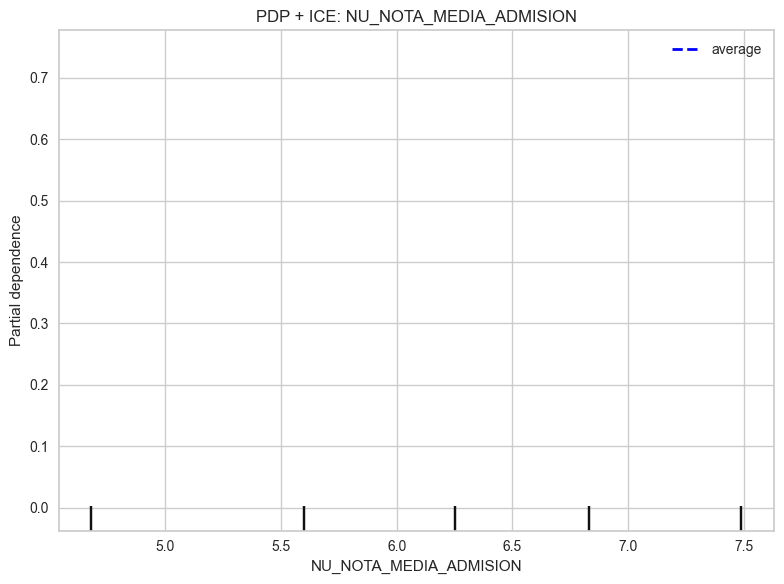


📊 PDP + ICE para NU_NOTA_MEDIA_1_BACH__PC


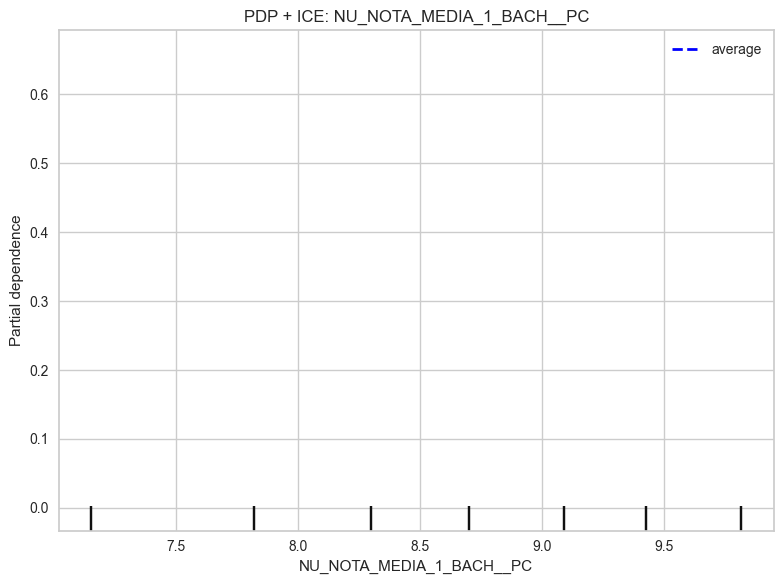


📊 PDP + ICE para PL_SITUACION_SOCIO_ECONOMICA


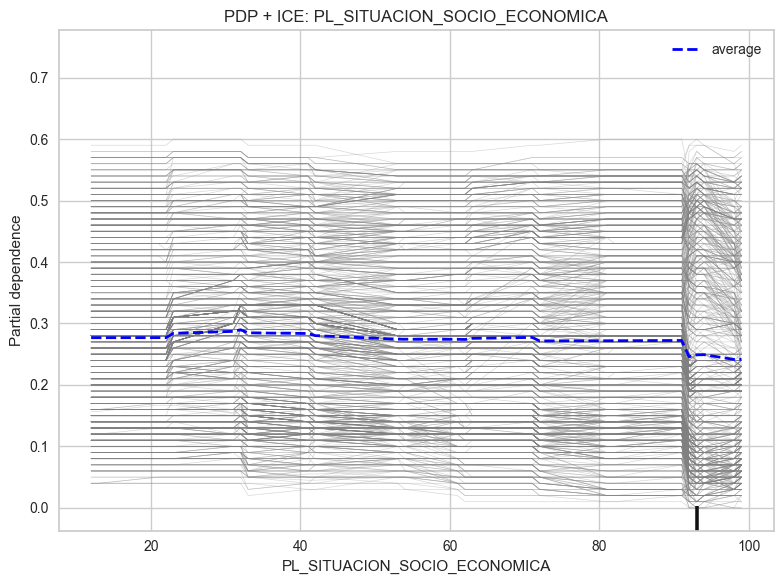


📊 PDP + ICE para PAID_PERCENT


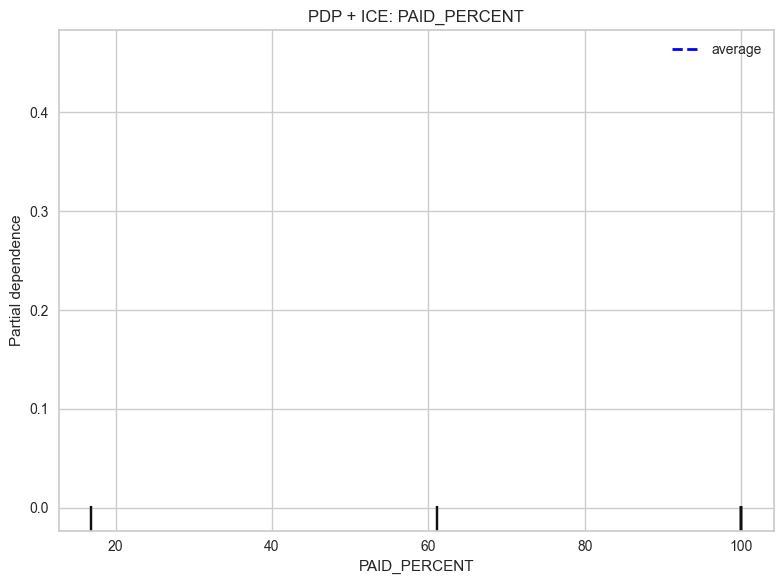


📊 PDP + ICE para CU_IMPORTE_TOTAL


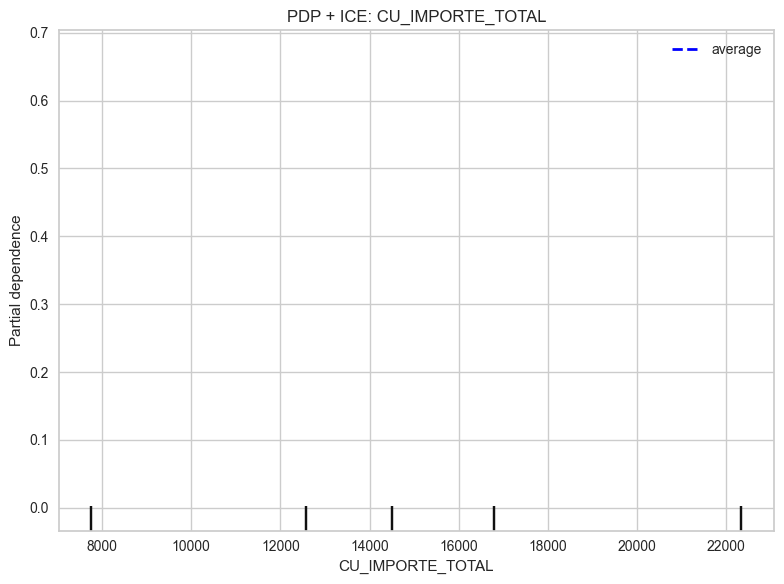


📊 PDP + ICE para tiempo_etapa_dias


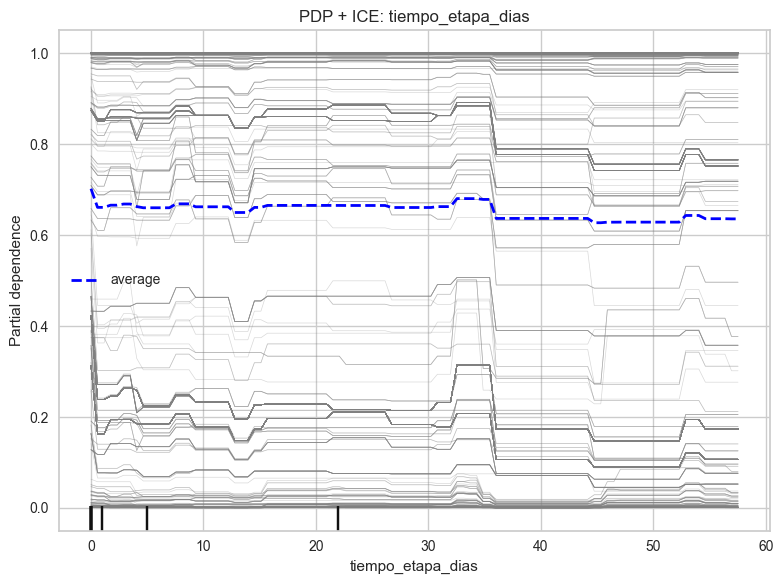


📊 PDP + ICE para PL_SITUACION_SOCIO_ECONOMICA


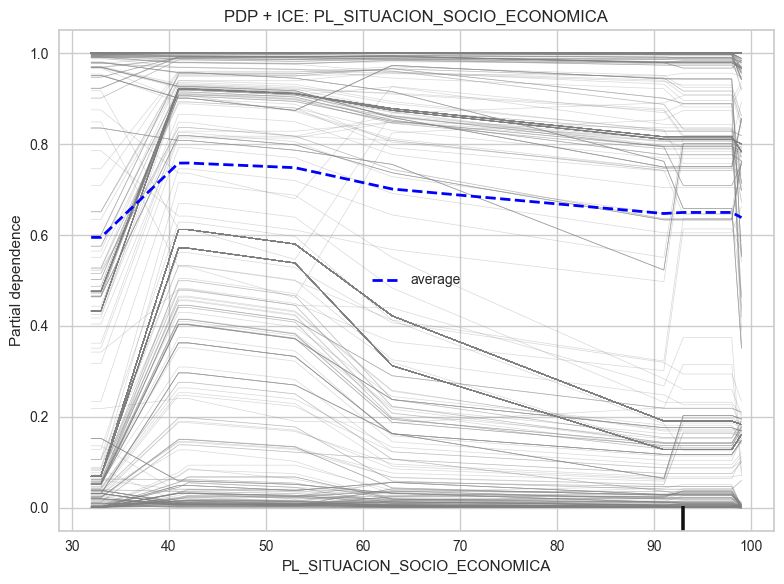


📊 PDP + ICE para NU_NOTA_MEDIA_1_BACH__PC


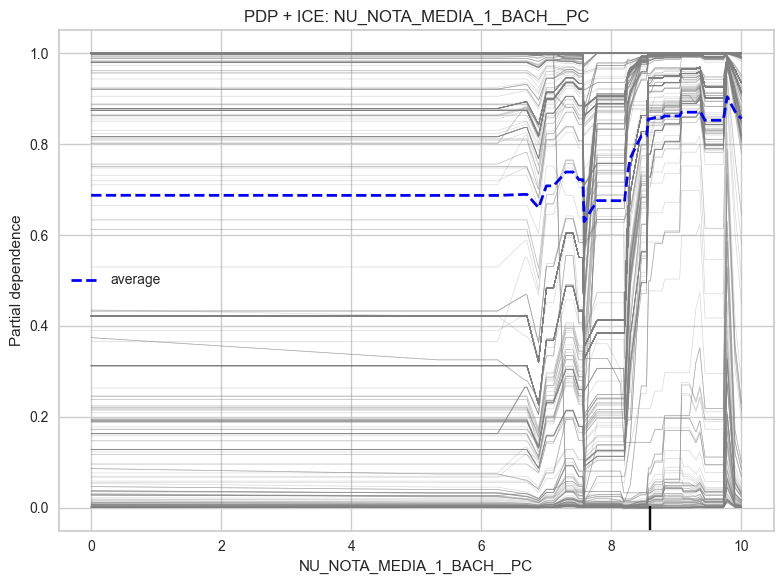


📊 PDP + ICE para PAID_PERCENT


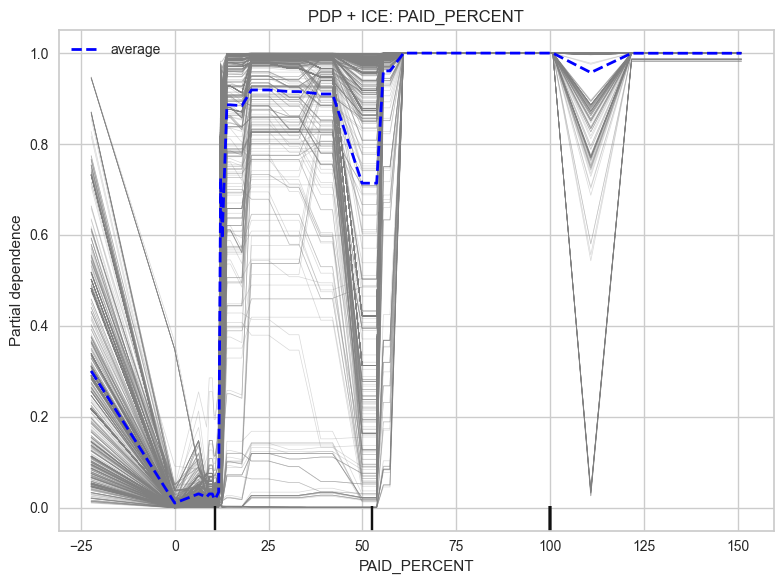


📊 PDP + ICE para CU_IMPORTE_TOTAL


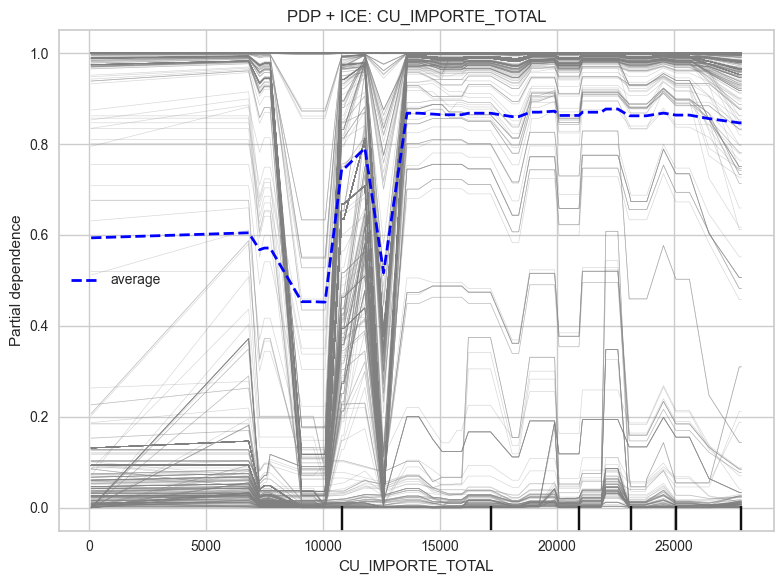

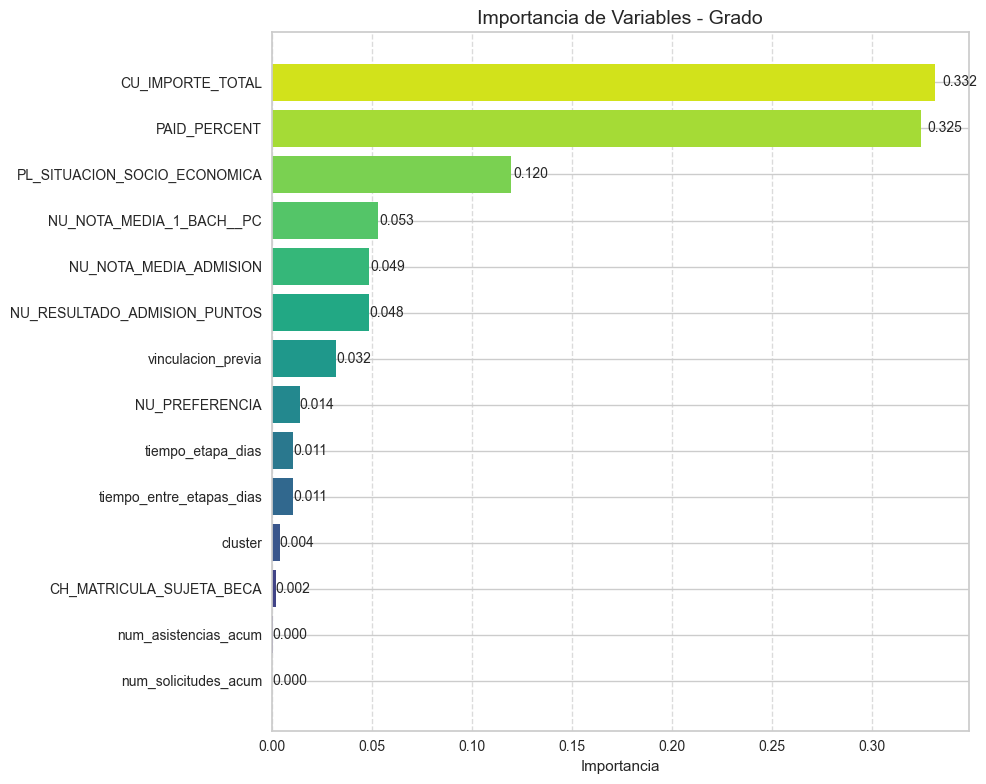

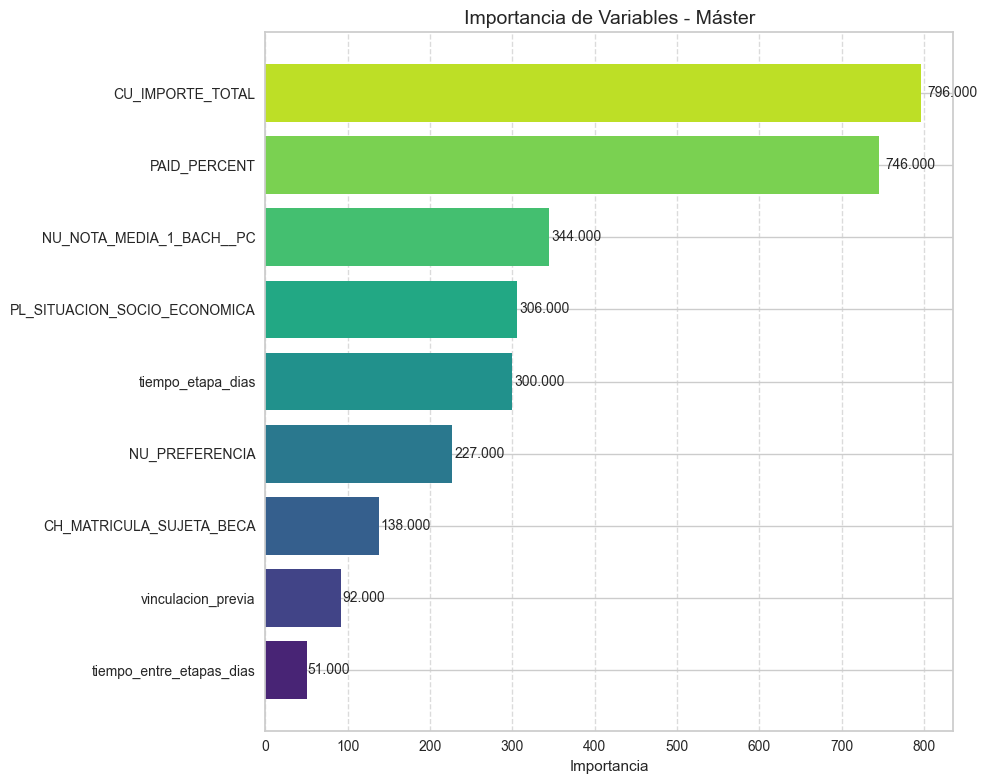

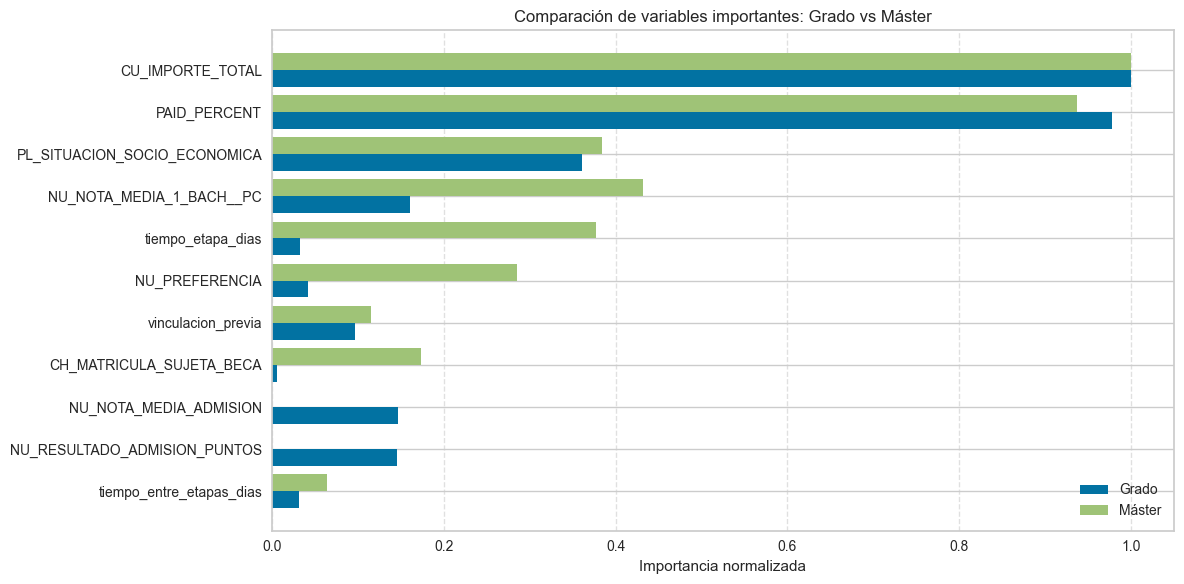

,Variable,Importancia_Grado,Importancia_Master
0,CU_IMPORTE_TOTAL,0.331702,796.0
1,PAID_PERCENT,0.324520,746.0
3,NU_NOTA_MEDIA_1_BACH__PC,0.053223,344.0
2,PL_SITUACION_SOCIO_ECONOMICA,0.119741,306.0
8,tiempo_etapa_dias,0.010813,300.0
7,NU_PREFERENCIA,0.013860,227.0
10,CH_MATRICULA_SUJETA_BECA,0.001936,138.0
6,vinculacion_previa,0.032117,92.0
9,tiempo_entre_etapas_dias,0.010633,51.0
4,NU_NOTA_MEDIA_ADMISION,0.048514,0.0


In [ ]:
# ============================================================
# 🔹 ANÁLISIS DE EXPLICABILIDAD Y COMPARACIÓN GRADO vs MÁSTER 
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
from pycaret.classification import load_model
from sklearn.inspection import permutation_importance

def alinear_columnas(modelo, X):
    columnas_modelo = modelo.feature_names_in_
    
    for col in columnas_modelo:
        if col not in X.columns:
            print(f"⚠️ Añadiendo columna faltante: {col}")
            X[col] = 0
    
    return X[columnas_modelo].copy()

print("🔹 Iniciando análisis de explicabilidad y comparación de variables...")

# ============================================================
# 0️⃣ CARGA DE MODELOS
# ============================================================
modelo_grado  = load_model(r"..\datos\04. Modelos\modelo_final_grado")
modelo_master = load_model(r"..\datos\04. Modelos\modelo_final_master")

# ============================================================
# 🔹 CARGA DATASETS (GRADO y MÁSTER)
# ============================================================

# --- DATASET GRADO ---
df_grado = pd.read_excel(r"..\datos\03. Datos analizados\test_grado_completo_con_scoring.xlsx")   # AJUSTA
TARGET_GRADO = 'target'                                          # AJUSTA

X_grado_full = df_grado.drop(columns=[TARGET_GRADO])
y_grado = df_grado[TARGET_GRADO]

# --- DATASET MÁSTER ---
df_master = pd.read_excel(r"..\datos\03. Datos analizados\test_master_completo_con_scoring.xlsx") # AJUSTA
TARGET_MASTER = 'target'                                          # AJUSTA

X_master_full = df_master.drop(columns=[TARGET_MASTER])
y_master = df_master[TARGET_MASTER]


# ============================================================
# 1️⃣ FILTRAR COLUMNAS USADAS POR CADA MODELO
# ============================================================
columnas_grado  = [c for c in modelo_grado.feature_names_in_ if c in X_grado_full.columns]
columnas_master = [c for c in modelo_master.feature_names_in_ if c in X_master_full.columns]

X_grado  = alinear_columnas(modelo_grado, X_grado_full[columnas_grado].copy())
X_master = alinear_columnas(modelo_master, X_master_full[columnas_master].copy())


print(f"✅ Columnas para Grado: {len(columnas_grado)}")
print(f"✅ Columnas para Máster: {len(columnas_master)}")

# ============================================================
# 2️⃣ FUNCIONES DE ANÁLISIS MEJORADAS
# ============================================================
def plot_importancia(modelo, X, top=20, titulo="Importancia de Variables"):
    """Gráfico horizontal con valores encima y degradado de color"""
    if hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_
    elif hasattr(modelo, 'coef_'):
        importancias = np.abs(modelo.coef_).flatten()
    else:
        print("⚠️ Este modelo no tiene atributo feature_importances_ ni coef_")
        return None

    if len(importancias) != X.shape[1]:
        print(f"⚠️ La longitud de las importancias ({len(importancias)}) no coincide con columnas X ({X.shape[1]}).")
        return None

    df_imp = pd.DataFrame({'Variable': X.columns, 'Importancia': importancias})
    df_imp = df_imp.sort_values('Importancia', ascending=True).tail(top)

    plt.figure(figsize=(10, max(6, top*0.4)))
    colors = sns.color_palette("viridis", len(df_imp))
    bars = plt.barh(df_imp['Variable'], df_imp['Importancia'], color=colors)
    plt.title(titulo, fontsize=14)
    plt.xlabel("Importancia")
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Mostrar valores encima de cada barra
    for bar in bars:
        w = bar.get_width()
        plt.text(w + 0.01*w, bar.get_y() + bar.get_height()/2, f"{w:.3f}", va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    return df_imp

def calcular_importancia_permutacion(modelo, X, y):
    r = permutation_importance(
        modelo, X, y,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    return pd.DataFrame({
        'Variable': X.columns,
        'Importancia': r.importances_mean
    })


def graficos_pdp_ice(modelo, X, features=None, top=5):
    """PDP en línea principal y ICE individuales en gris"""
    if features is None:
        if hasattr(modelo, 'feature_importances_'):
            imp = modelo.feature_importances_
        elif hasattr(modelo, 'coef_'):
            imp = np.abs(modelo.coef_).flatten()
        else:
            print("⚠️ Modelo no tiene importancias.")
            return
        features = np.array(X.columns)[np.argsort(imp)[-top:]].tolist()

    for f in features:
        try:
            print(f"\n📊 PDP + ICE para {f}")
            fig, ax = plt.subplots(figsize=(8,6))
            PartialDependenceDisplay.from_estimator(
                modelo, X, [f], kind='both', 
                ice_lines_kw={'color':'gray','alpha':0.3},
                pd_line_kw={'color':'blue','linewidth':2},
                ax=ax
            )
            plt.title(f"PDP + ICE: {f}")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"⚠️ No se pudo generar PDP/ICE para {f}: {e}")

def comparar_importancia(df_imp_grado, df_imp_master):
    comparacion = pd.merge(
        df_imp_grado, df_imp_master,
        on='Variable',
        how='outer',
        suffixes=('_Grado', '_Master')
    ).fillna(0)
    comparacion['Diferencia'] = comparacion['Importancia_Master'] - comparacion['Importancia_Grado']
    comparacion = comparacion.sort_values('Diferencia', key=abs, ascending=False)

    # Gráfico comparativo de barras
    plt.figure(figsize=(10,6))
    comparacion_top = comparacion.head(10)
    x = np.arange(len(comparacion_top))
    width = 0.35
    plt.barh(x - width/2, comparacion_top['Importancia_Grado'], width, label='Grado', color='skyblue')
    plt.barh(x + width/2, comparacion_top['Importancia_Master'], width, label='Máster', color='orange')
    plt.yticks(x, comparacion_top['Variable'])
    plt.xlabel("Importancia")
    plt.title("Top 10 Diferencias Importancia: Grado vs Máster")
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\n📊 Comparación de importancia de variables Grado vs Máster (top 10 por diferencia):")
    print(comparacion_top[['Variable','Importancia_Grado','Importancia_Master','Diferencia']])
    return comparacion

# ============================================================
# PREPARACIÓN CORRECTA DE FEATURES
# ============================================================

# Eliminar target si está en X
X_grado = X_grado.drop(columns=['target'], errors='ignore')
X_master = X_master.drop(columns=['target'], errors='ignore')

# Alinear columnas de forma segura (ignorando target si aparece)
if hasattr(modelo_grado, 'feature_names_in_'):
    columnas_validas = [
        c for c in modelo_grado.feature_names_in_
        if c in X_grado.columns
    ]
    X_grado = X_grado[columnas_validas].copy()

if hasattr(modelo_master, 'feature_names_in_'):
    columnas_validas = [
        c for c in modelo_master.feature_names_in_
        if c in X_master.columns
    ]
    X_master = X_master[columnas_validas].copy()


# ============================================================
# 3️⃣ EJECUTAR ANÁLISIS PARA GRADO
# ============================================================

df_imp_grado  = calcular_importancia_permutacion(
    modelo_grado, X_grado, y_grado
)

graficos_pdp_ice(modelo_grado, X_grado, top=5)

# ============================================================
# 4️⃣ EJECUTAR ANÁLISIS PARA MÁSTER
# ============================================================

df_imp_master = calcular_importancia_permutacion(
    modelo_master, X_master, y_master
)

graficos_pdp_ice(modelo_master, X_master, top=5)

# ============================================================
# 5️⃣ COMPARACIÓN GRADO vs MÁSTER
# ============================================================

# ============================================================
# 🔹 Calcular importancias
# ============================================================
df_imp_grado  = plot_importancia(modelo_grado, X_grado, top=20, titulo="Importancia de Variables - Grado")
df_imp_master = plot_importancia(modelo_master, X_master, top=20, titulo="Importancia de Variables - Máster")


# ============================================================
# 🔹 COMPARACIÓN FINAL GRADO vs MÁSTER (BLOQUE CORREGIDO)
# ============================================================

# Top 10 de cada modelo
top_grado = df_imp_grado.sort_values('Importancia', ascending=False).head(10)
top_master = df_imp_master.sort_values('Importancia', ascending=False).head(10)

# Unir variables relevantes
top_vars = pd.concat([top_grado, top_master]) \
    .drop_duplicates(subset='Variable') \
    .reset_index(drop=True)

# Añadir importancias de ambos modelos
top_vars = top_vars[['Variable']].merge(
    df_imp_grado.rename(columns={'Importancia':'Importancia_Grado'}),
    on='Variable',
    how='left'
).merge(
    df_imp_master.rename(columns={'Importancia':'Importancia_Master'}),
    on='Variable',
    how='left'
)

# Rellenar NaN
top_vars[['Importancia_Grado','Importancia_Master']] = \
    top_vars[['Importancia_Grado','Importancia_Master']].fillna(0)

# ==========================
# 🔹 NORMALIZACIÓN (CLAVE)
# ==========================
top_vars['Importancia_Grado_N'] = (
    top_vars['Importancia_Grado'] / top_vars['Importancia_Grado'].max()
    if top_vars['Importancia_Grado'].max() > 0 else 0
)

top_vars['Importancia_Master_N'] = (
    top_vars['Importancia_Master'] / top_vars['Importancia_Master'].max()
    if top_vars['Importancia_Master'].max() > 0 else 0
)

# Ordenar para visualización
top_vars['Importancia_Total'] = (
    top_vars['Importancia_Grado_N'] + top_vars['Importancia_Master_N']
)
top_vars = top_vars.sort_values('Importancia_Total', ascending=True)

# ==========================
# 🔹 GRÁFICO FINAL
# ==========================
indices = np.arange(len(top_vars))
width = 0.4

plt.figure(figsize=(12,6))
plt.barh(indices - width/2, top_vars['Importancia_Grado_N'], width, label='Grado')
plt.barh(indices + width/2, top_vars['Importancia_Master_N'], width, label='Máster')

plt.yticks(indices, top_vars['Variable'])
plt.xlabel("Importancia normalizada")
plt.title("Comparación de variables importantes: Grado vs Máster")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Tabla resumen
display(
    top_vars[['Variable','Importancia_Grado','Importancia_Master']]
    .sort_values(
        by=['Importancia_Master','Importancia_Grado'],
        ascending=False
    )
)

